In [1]:
import os
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
import imageio

Using backend: tensorflow.compat.v1

2024-09-09 14:25:48.856694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-09 14:25:49.394908: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


Instructions for updating:
non-resource variables are not supported in the long term



In [2]:
os.makedirs("training_outputs", exist_ok=True)

Compiling model...
Building feed-forward neural network...
'build' took 0.033230 s



/rds/general/user/jh2119/home/.conda/envs/FYP/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.364707 s

Initializing variables...
Training model...

Step      Train loss    Test loss     Test metric   
0         [6.40e+05]    [6.40e+05]    [1.31e+03]    
1000      [5.70e+05]    [5.70e+05]    [8.70e+02]    
2000      [5.70e+05]    [5.70e+05]    [8.48e+02]    
3000      [5.11e+05]    [5.11e+05]    [1.01e+03]    
4000      [4.19e+05]    [4.19e+05]    [8.35e+02]    
5000      [3.63e+05]    [3.63e+05]    [7.28e+02]    
6000      [2.82e+05]    [2.82e+05]    [5.79e+02]    
7000      [2.58e+05]    [2.58e+05]    [5.25e+02]    
8000      [1.91e+05]    [1.91e+05]    [3.91e+02]    
9000      [1.41e+05]    [1.41e+05]    [2.90e+02]    
10000     [1.01e+05]    [1.01e+05]    [2.07e+02]    
11000     [6.53e+04]    [6.53e+04]    [1.37e+02]    
12000     [3.38e+04]    [3.38e+04]    [7.37e+01]    
13000     [1.00e+05]    [1.00e+05]    [1.99e+02]    
14000     [6.00e+04]    [6.00e+04]    [1.20e+02]    
15000     [3.35e+04]    [3.35e+04]    [6.73e+01]    
16000     [2.02e+04]    [2.

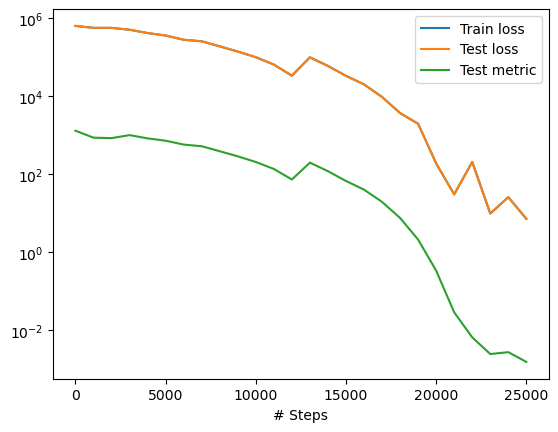

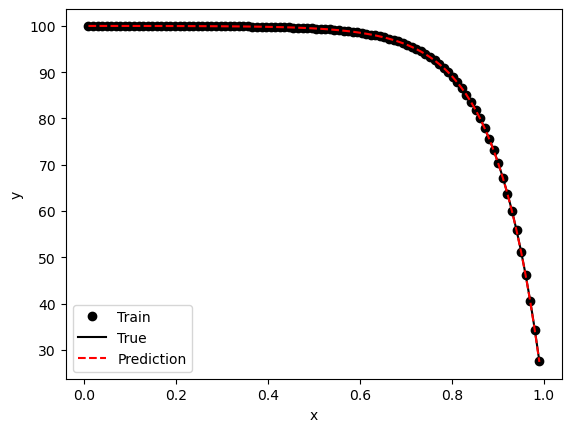

/var/tmp/pbs.25673.pbs-7/ipykernel_185428/846885083.py:88: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [4]:
length = 1
T_hot = 100
T_cold = 20
diff_coeff = 1
density = 1
u = 10

geom = dde.geometry.Interval(0,length)

def pde(x,y):
  dy_dx = dde.grad.jacobian(y,x)
  d2y_dx2 = dde.grad.hessian(y,x)

  return density * u * dy_dx - diff_coeff * d2y_dx2


def func(x):
  return T_hot + (np.exp(density * u * x / diff_coeff)-1) / (np.exp(density * u * length / diff_coeff)-1) * (T_cold - T_hot)

# What works: uniform distribution
data = dde.data.PDE(geom,
                    pde,
                    [],
                    num_domain=100, 
                    solution=func,
                    num_test=100,
                    train_distribution='uniform')

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation,initializer)

def output_transform(x, y):
    return T_hot + (T_cold - T_hot) * x / length + x * (x - length) * y

net.apply_output_transform(output_transform)

def plot_and_save(step, model):
    # Predict the solution
    y_pred = model.predict(x)
    y_true = func(x)

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    plt.plot(x, y_true,'-x',color='#22223B',alpha=0.7,markersize=5, label='Analytical Solution')
    plt.plot(x, y_pred,'--',color='#D36135', label='PINN Prediction')
    plt.title(f'Solution at step {step}',fontsize=14,fontweight='bold',color='#22223B')
    plt.xlabel('x')
    plt.ylabel('Temperature')
    plt.legend(loc='lower left',fontsize=12,frameon=True,shadow=True,facecolor='white')

    # Save the plot
    plt.savefig(f"training_outputs/step_{step:06d}.png")
    plt.close()

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

class PlotCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.step = 0

    def on_epoch_end(self):
        if self.step == 0:
          plot_and_save(self.step, self.model)
        self.step += 1
        if self.step % 50 == 0:  # Save plot every 50 steps
            plot_and_save(self.step, self.model)

# Create the callback
plot_callback = PlotCallback()

model = dde.Model(data,net)
model.compile("adam", lr=0.001,metrics=["MSE"])
losshistory, train_state = model.train(iterations=25000,callbacks=[plot_callback])

dde.saveplot(losshistory,train_state,issave=False,isplot=True)

def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

# Create the animation
create_gif('training_outputs', 'training_animation.gif')


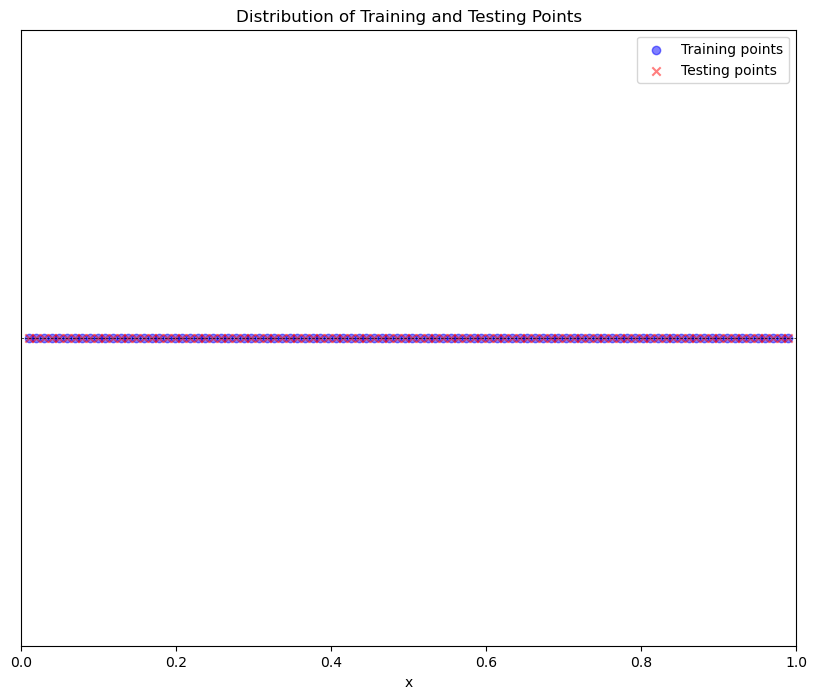

In [5]:
# Obtain training and testing points
train_x = data.train_x
test_x = data.test_x

plt.figure(figsize=(10,8))
plt.scatter(train_x,np.zeros_like(train_x),c='blue',marker='o',label='Training points',alpha=0.5)
plt.scatter(test_x,np.zeros_like(test_x),c='red',marker='x',label='Testing points',alpha=0.5)
plt.title('Distribution of Training and Testing Points')
plt.xlabel('x')
plt.legend()
plt.yticks([])
plt.axhline(y=0,color='k',linestyle='--',linewidth=0.5)
plt.ylim(-0.5,0.5)
plt.xlim(0,1)
plt.show()

## With two observed points

Compiling model...
Building feed-forward neural network...
'build' took 0.031344 s



/rds/general/user/jh2119/home/.conda/envs/FYP/lib/python3.9/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.307273 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [8.12e-01, 1.00e+04, 3.96e+02, 5.20e+03]    [8.11e-01, 1.00e+04, 3.96e+02, 5.20e+03]    [8.61e+03]    
1000      [3.54e+00, 2.03e+03, 4.85e-01, 1.01e+03]    [2.60e+00, 2.03e+03, 4.85e-01, 1.01e+03]    [1.70e+03]    
2000      [1.83e+01, 2.57e+02, 6.43e-01, 1.29e+02]    [1.48e+01, 2.57e+02, 6.43e-01, 1.29e+02]    [2.15e+02]    
3000      [9.86e+00, 1.44e+01, 1.21e-02, 7.19e+00]    [9.34e+00, 1.44e+01, 1.21e-02, 7.19e+00]    [1.22e+01]    
4000      [1.46e+00, 3.43e-01, 9.18e-03, 1.76e-01]    [1.46e+00, 3.43e-01, 9.18e-03, 1.76e-01]    [3.20e-01]    
5000      [2.05e+01, 8.67e-03, 3.04e-01, 1.57e-01]    [1.57e+01, 8.67e-03, 3.04e-01, 1.57e-01]    [2.44e-02]    

Best model at step 4000:
  train loss: 1.98e+00
  test loss: 1.99e+00
  test metric: [3.20e-01]

'train' took 18.634398 s



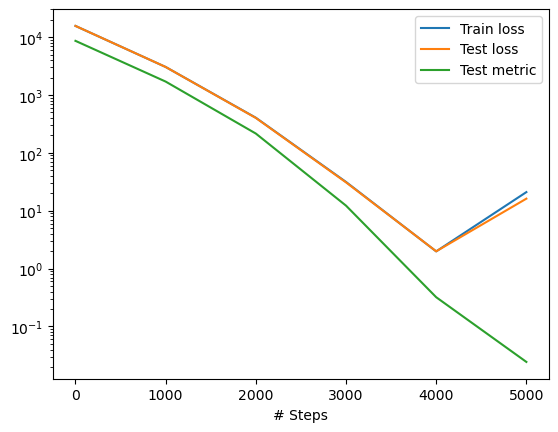

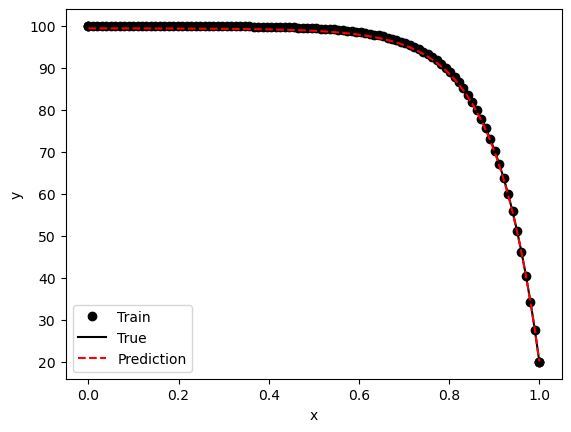

/var/tmp/pbs.25673.pbs-7/ipykernel_185428/2670770623.py:102: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


In [9]:
os.makedirs("training_outputs_obs", exist_ok=True)

length = 1
T_hot = 100
T_cold = 20
diff_coeff = 1
density = 1
u = 10

geom = dde.geometry.Interval(0,length)

def pde(x,y):
  dy_dx = dde.grad.jacobian(y,x)
  d2y_dx2 = dde.grad.hessian(y,x)

  return density * u * dy_dx - diff_coeff * d2y_dx2


def func(x):
  return T_hot + (np.exp(density * u * x / diff_coeff)-1) / (np.exp(density * u * length / diff_coeff)-1) * (T_cold - T_hot)

data_x = np.array([0,1]).reshape((2,1))
data_y = func(data_x)

def boundary_left(x,on_boundary):
  return on_boundary and np.isclose(x[0],0)
def boundary_right(x,on_boundary):
  return on_boundary and np.isclose(x[0],1)
    
bc_left = dde.icbc.DirichletBC(geom, lambda x: T_hot, boundary_left)
bc_right = dde.icbc.DirichletBC(geom, lambda x: T_cold, boundary_right)
observe = dde.icbc.PointSetBC(data_x,data_y)

# What works: uniform distribution
data = dde.data.PDE(geom,
                    pde,
                    [bc_left,bc_right,observe],
                    num_domain=100, 
                    solution=func,
                    num_test=100,
                    train_distribution='uniform',
                    anchors=data_x)

layer_size = [1] + [50] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation,initializer)

def plot_and_save(step, model):
    # Predict the solution
    y_pred = model.predict(x)
    y_true = func(x)

    # Create the plot
    plt.figure(figsize=(8, 5))
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.gca().set_facecolor('#f0f0f0')
    plt.plot(x, y_true,'-x',color='#2F195F',alpha=0.7,markersize=5, label='Analytical Solution')
    plt.scatter(data_x,data_y,marker='o',s=50,facecolors='none',edgecolors='#A09EBB',label='Data points')
    plt.plot(x, y_pred,'--',color='#37FF8B', label='PINN Prediction')
    plt.title(f'Solution at step {step}',fontsize=14,fontweight='bold',color='#2F195F')
    plt.xlabel('x')
    plt.ylabel('Temperature')
    plt.legend(loc='lower left',fontsize=12,frameon=True,shadow=True,facecolor='white')

    # Save the plot
    plt.savefig(f"training_outputs_obs/step_{step:06d}.png")
    plt.close()

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

class PlotCallback(dde.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.step = 0

    def on_epoch_end(self):
        if self.step == 0:
          plot_and_save(self.step, self.model)
        self.step += 1
        if self.step % 50 == 0:  # Save plot every 50 steps
            plot_and_save(self.step, self.model)

# Generate points for prediction
x = np.linspace(0, length, 50)[:, None]

# Create the callback
plot_callback = PlotCallback()

model = dde.Model(data,net)
model.compile("adam", lr=0.001,metrics=["MSE"])
losshistory, train_state = model.train(iterations=5000,callbacks=[plot_callback])

dde.saveplot(losshistory,train_state,issave=False,isplot=True)

def create_gif(image_folder, gif_name):
    images = []
    for file_name in sorted(os.listdir(image_folder)):
        if file_name.endswith('.png'):
            file_path = os.path.join(image_folder, file_name)
            images.append(imageio.imread(file_path))
    imageio.mimsave(gif_name, images, fps=20)

# Create the animation
create_gif('training_outputs_obs', 'training_animation_obs.gif')